In [1]:
from langgraph.graph import MessagesState, StateGraph, START, END
from langchain_core.tools import tool
from langchain_core.messages import SystemMessage, HumanMessage, AIMessage, ToolMessage
from langgraph.prebuilt import ToolNode, tools_condition
from langgraph.checkpoint.memory import MemorySaver
from langchain_google_vertexai import ChatVertexAI
from langchain_google_vertexai import VertexAIEmbeddings
from langchain_openai import ChatOpenAI
from langsmith import traceable
from langchain.schema import Document
from pydantic import BaseModel, Field
from typing import Optional, Dict, Literal, List, NotRequired, Annotated, TypedDict
from operator import add
from langchain_milvus import Milvus

import json

from langgraph.constants import Send

from IPython.display import Image, display, Markdown

from dotenv import load_dotenv
load_dotenv()

True

In [2]:
URI = "./milvus_vector_database_0215.db"
embeddings = VertexAIEmbeddings(model="text-embedding-005")

vector_store = Milvus(embeddings, connection_args={"uri": URI})

In [3]:

#llm = ChatVertexAI(model="gemini-2.0-pro-exp-02-05", temperature=0)
#llm = ChatVertexAI(model="gemini-2.0-flash-exp", temperature=0)
llm = ChatOpenAI(model="gpt-4o", temperature=0)

In [4]:
class NeedSearch(BaseModel):
    need_search: bool = Field(..., description="Whether the user's query related to technology innovation management and needs to be searched in the vector database.")
    sub_queries: Optional[List[str]] = Field(description="The sub queries that need to be searched in the vector database. As specific as possible.")
    response: Optional[str] = Field(description="The response that address the user's query.")

class TimReviewState(MessagesState):
    need_search: bool
    sub_queries: List[str]
    search_results: Annotated[list, add]
    
class SearchState(TypedDict):
    sub_query: str
    query_tool_call: AIMessage
    search_results: Annotated[list, add]
    
class RetrieveInput(BaseModel):
    query: str = Field(description="The query to retrieve the answer for in cosine similarity. ")
    filter: str = Field(description="""
    To be used to filter through metadata. Confirm to Milvus filter format. 
    Available metadata fields are 'year' and 'author'.
    The filed 'year' is a number, and it can be used with operators like '>=', '<=', '==', '!=', '>', '<'.
    The filed 'author' is a string. Author names are connected with 'and'. Use 'LIKE' operator to search for a specific author.
    For example, "((( year >= 2013 ) and ( year <= 2017 )) and ( author like '%Mika Westerlund%' ))". When it comes to the author, use the "LIKE" operator.
    """)

In [34]:
# Prompts

query_or_respond_system_message = """
Your are an expert on technology innovation management.
You are given a query by the user specified in the user message.
You are to retrieve information related to the query from around 700 articles from the Tim Review Journal.
The retrieval is done using a vector similarity search.
You should decide whether a research is required.
If research is required, handle the query properly.
If more than one topics are involved in the query, no matter how the question is asked, you must divide the query into subqueries. This division rule is very important, take special care of it. 
If the query involves different topics, divide the query into subqueries as specific as possible. For example, if the query is about the difference between topic A and topic B, divide it into two subqueries, one for topic A and the other for topic B.
If there is authors, time, etc. involved, your should specify them in every subquery separately.
If a research is not required, address the user properly based on the conversation history.

<conversation_history>
{history}
</conversation_history> 

"""

query_formatting_system_message = """
Refine the natural langauge query into a format that can be used in the vector database search.
If the originalquery is about searching for a document that is by one or a centain number of authors, the authors should be specified in the filter field, not this the query field.
"""

summarize_system_message = """
Your are an expert on technology innovation management.
You've decided that the user's query is clear and related to technology innovation management.
You've also retrieved and got the documents related to the query from around 700 articles from the Tim Review Journal.
Scrunize if the documents are relevant to the user's query. Ignore those that are not relevant.
Summarize a answer to the user's query based on the relevant documents.
<documents>
{documents}
</documents>

Instructions:
1. Dividen the summary into three parts: Original Text, Summary, and References. Quote the title of each part by *.
2. The Original Text is the original text from the documents that is related to the user's query. The original text must be directly from the original text. It must be double quoted. 
3. In the summary part, summarize an answer to the user's query based on the oringinal text.
4. Give a reference to all the papers cited. When italizing the title of the paper, use the _ symbol.
5. Use inline citation whenever necessary.
6. Use APA 7th edition format for citation and references as default unless the user specifies otherwise.
7. If no douments are relevant, inform the user that no relevant documents are found. Just give a brief explanation, ignoring the instruction that is to divide it into three part.
"""

In [35]:
@traceable
def query_response(state: TimReviewState):
    system_message = SystemMessage(content=query_or_respond_system_message.format(history=state['messages']))
    subquery_llm = llm.with_structured_output(NeedSearch)
    result = subquery_llm.invoke([system_message, state['messages'][-1]])
    print("============== Analyzing user query ==============")
    
    if result.need_search:
        print(f"The number of subqueries: {len(result.sub_queries)}")
        print("Subqueries:")
        display(result.sub_queries)
        return {"need_search":result.need_search, "sub_queries": result.sub_queries}
    else: 
        print("No subquery.")
        return {"need_search":result.need_search, "messages": result.response}
    
def summarize(state: TimReviewState):
    print("============= Summarizing =============")
    print("Current state:")
    display(state)
    system_message = SystemMessage(content=summarize_system_message.format(documents=state['search_results']))
    result = llm.invoke([system_message] + state['messages'])
    return {"messages": result}

In [36]:
@tool("retrieve", args_schema=RetrieveInput)
def retrieve(query: str, filter: str):
    """
    Retrieve information from the literatures related to a query.
    
    param query: The query to search for in cosine similarity.
    param filter: The filter that used to filter through metadata.
        
    return: A list of the retrieved documents    
    
    """
    print("===========  Retrieving  ===========")
    print("Query: ", query)
    print("Filter: ", filter)
    result = vector_store.similarity_search(query, k=5, expr=filter)
    print("Result:")
    display(result)
    return result

@traceable
def retrieve_tool_node(state: SearchState):
    result = retrieve.invoke(state["query_tool_call"].tool_calls[0]['args'])
    return {"search_results": result}

In [37]:
@traceable
def generate_query_tool_call(state: SearchState):
    system_message = SystemMessage(content=query_formatting_system_message)
    tools = [retrieve]
    tool_llm = llm.bind_tools(tools)
    result = tool_llm.invoke([system_message, state['sub_query']])
    print("===========  Generate Query Tool Call ===========")
    display(result)
    return {"query_tool_call": result}

In [38]:
search_graph_builder = StateGraph(SearchState)
search_graph_builder.add_node("generate_query_tool_call", generate_query_tool_call)
search_graph_builder.add_node("retrieve_tool_node", retrieve_tool_node)

search_graph_builder.add_edge(START, "generate_query_tool_call")
search_graph_builder.add_edge("generate_query_tool_call", "retrieve_tool_node")
search_graph_builder.add_edge("retrieve_tool_node", END)

search_graph = search_graph_builder.compile()
#display(Image(search_graph.get_graph(xray=1).draw_mermaid_png()))



In [39]:
def initiate_all_searches(state: TimReviewState):
    if state['need_search']:
        return [Send("conduct_searches", {"sub_query": sub_query}) for sub_query in state['sub_queries']]
    else:
        return END

In [40]:


graph_builder = StateGraph(TimReviewState)
graph_builder.add_node("query_response", query_response)
graph_builder.add_node("conduct_searches", search_graph_builder.compile())
graph_builder.add_node("summarize", summarize)

graph_builder.add_edge(START, "query_response")
graph_builder.add_conditional_edges("query_response", initiate_all_searches, ["conduct_searches", END])
graph_builder.add_edge("conduct_searches", "summarize")
graph_builder.add_edge("summarize", END)
graph_builder.add_edge("query_response", END)

memory = MemorySaver()
#graph = graph_builder.compile()
graph = graph_builder.compile(checkpointer=memory)
    

In [41]:
def get_graph():
    return graph

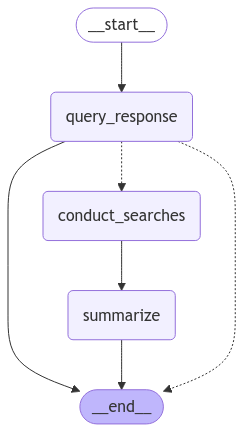

In [42]:
if __name__ == "__main__": 
    
    display(Image(graph.get_graph().draw_mermaid_png()))

In [54]:
if __name__ == "__main__": 
    config = {"configurable": {"thread_id": "2"}}
    #message = "What's different between digitalization and digital transformation? Use paper between 2013 and 2023 to answer it."
    #message = "What's digitalization?"
    #message = "What's digital transformation?"
    message = "What's the difference between them?"
    #message = "Say it again?"
    result = graph.invoke({"messages": message}, config)

Failed to get inputs for (state: __main__.TimReviewState): got an unexpected keyword argument 'config'


============== Analyzing user query ==============
The number of subqueries: 2
Subqueries:


['Digitalization', 'Digital Transformation']

Failed to get inputs for (state: __main__.SearchState): got an unexpected keyword argument 'config'
Failed to get inputs for (state: __main__.SearchState): got an unexpected keyword argument 'config'


===========  Generate Query Tool Call ===========


AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_bIJN1XBEFJWv7X0K4n3FBpxa', 'function': {'arguments': '{"query":"Digitalization","filter":""}', 'name': 'retrieve'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 19, 'prompt_tokens': 291, 'total_tokens': 310, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-2024-08-06', 'system_fingerprint': 'fp_5e115050d0', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run-69afaff4-e508-4506-a936-3eac8d2c318d-0', tool_calls=[{'name': 'retrieve', 'args': {'query': 'Digitalization', 'filter': ''}, 'id': 'call_bIJN1XBEFJWv7X0K4n3FBpxa', 'type': 'tool_call'}], usage_metadata={'input_tokens': 291, 'output_tokens': 19, 'total_tokens': 310, 'input_token_details': {'audio': 0, 'cache_read': 0}, 'output_token_

Failed to get inputs for (state: __main__.SearchState): got an unexpected keyword argument 'config'


===========  Retrieving  ===========
Query:  Digitalization
Filter:  
===========  Generate Query Tool Call ===========


AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_uNcvqdJgsgjUyt0Pz3dBPrmz', 'function': {'arguments': '{"query":"Digital Transformation","filter":""}', 'name': 'retrieve'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 19, 'prompt_tokens': 291, 'total_tokens': 310, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-2024-08-06', 'system_fingerprint': 'fp_5e115050d0', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run-e36de313-e897-4706-8608-9533d4ffa68c-0', tool_calls=[{'name': 'retrieve', 'args': {'query': 'Digital Transformation', 'filter': ''}, 'id': 'call_uNcvqdJgsgjUyt0Pz3dBPrmz', 'type': 'tool_call'}], usage_metadata={'input_tokens': 291, 'output_tokens': 19, 'total_tokens': 310, 'input_token_details': {'audio': 0, 'cache_read': 0}

Failed to get inputs for (state: __main__.SearchState): got an unexpected keyword argument 'config'


===========  Retrieving  ===========
Query:  Digital Transformation
Filter:  
Result:


[Document(metadata={'abstract': 'Due to its unique features and accessibility, the focus of implementing digital technology is no longer just to improve internal operations, but to expand internal dimensions, reach customers and external partners, affect services, integrate processes, disrupt markets, and fundamentally change industries. It is no surprise that the notion of digital transformation has garnered much research interest, especially from the practitioners\\textquoteright point of view, but academic achievements are somehow lagging behind, possibly because frameworks for digital transformation are still evolving. In this article, we tried to address that gap by conducting holistic research of digital transformation in companies. We used a series of in-depth interviews to inform comprehensive case studies of three companies from different industries that are in different stages of digital transformation. We carefully investigated the companies\\textquoteright experiences in th

Result:


[Document(metadata={'abstract': 'Due to its unique features and accessibility, the focus of implementing digital technology is no longer just to improve internal operations, but to expand internal dimensions, reach customers and external partners, affect services, integrate processes, disrupt markets, and fundamentally change industries. It is no surprise that the notion of digital transformation has garnered much research interest, especially from the practitioners\\textquoteright point of view, but academic achievements are somehow lagging behind, possibly because frameworks for digital transformation are still evolving. In this article, we tried to address that gap by conducting holistic research of digital transformation in companies. We used a series of in-depth interviews to inform comprehensive case studies of three companies from different industries that are in different stages of digital transformation. We carefully investigated the companies\\textquoteright experiences in th

============= Summarizing =============
Current state:


{'messages': [HumanMessage(content="What's digitalization?", additional_kwargs={}, response_metadata={}, id='499dd470-c1b5-4811-94fb-60f91990b7ab'),
  AIMessage(content='*Original Text*\n\n"Nowadays, many societies are experiencing a new wave of digitalization (Legner et al., 2017), characterized by the emergence and converging of many innovative technologies in the domains of robotics, artificial intelligence, the internet of things, mobile applications, augmented and virtual reality, big data, cloud, 3D printers, blockchain, nanotechnology, biotechnology, and quantum computing. The application and overlap of these digital technologies are impacting many segments of companies by drastically transforming and dematerializing temporal and spatial dimensions of businesses, as well as expanding global access" (Hervé et al., 2020).\n\n"A quite different term, digitalization is instead a general tool for BM innovation, as it can contribute to the shift from product to service based businesse

In [ ]:
#display(result['messages'])

[HumanMessage(content="What's digitalization?", additional_kwargs={}, response_metadata={}, id='499dd470-c1b5-4811-94fb-60f91990b7ab'),
 AIMessage(content='*Original Text*\n\n"Nowadays, many societies are experiencing a new wave of digitalization (Legner et al., 2017), characterized by the emergence and converging of many innovative technologies in the domains of robotics, artificial intelligence, the internet of things, mobile applications, augmented and virtual reality, big data, cloud, 3D printers, blockchain, nanotechnology, biotechnology, and quantum computing. The application and overlap of these digital technologies are impacting many segments of companies by drastically transforming and dematerializing temporal and spatial dimensions of businesses, as well as expanding global access" (Hervé et al., 2020).\n\n"A quite different term, digitalization is instead a general tool for BM innovation, as it can contribute to the shift from product to service based businesses. DT relates 

In [ ]:
#display(Markdown(result['messages'][-1].content))

*Original Text*

"Digitalization describes the integration of digital technologies into any aspect of daily life that can be digitized (Gray & Rumpe, 2015; Khan, 2016). However, Gartner (2018) defines digitalization with a more business-oriented focus: 'Digitalization is the use of digital technologies to change a business model and provide new revenue and value-producing opportunities; it is the process of moving to a digital business'" (Neubert, 2018).

"Digital transformation can be comprehended as a continuous process of climbing the scale of digital maturity by employing digital and other technologies along with organizational practices to create a digital culture. Ultimately, this maturity will enable the company to provide better services, gain competitive advantage, and effectively respond to actions in a complex environment" (Ivančić et al., 2019).

*Summary*

The primary difference between digitalization and digital transformation lies in their scope and objectives. Digitalization refers to the integration of digital technologies into various aspects of life or business, often focusing on changing business models and creating new revenue opportunities (Neubert, 2018). It is about converting processes to digital formats and leveraging technology to enhance business operations. On the other hand, digital transformation is a broader, more comprehensive process that involves not only the adoption of digital technologies but also the creation of a digital culture within an organization. It aims to achieve digital maturity, enabling companies to provide better services, gain competitive advantages, and adapt effectively to complex environments (Ivančić et al., 2019).

*References*

Neubert, M. (2018). _The Impact of Digitalization on the Speed of Internationalization of Lean Global Startups_. Technology Innovation Management Review, 8(5), 44-54. http://doi.org/10.22215/timreview/1158

Ivančić, L., Bosilj Vukšić, V., & Spremi, M. (2019). _Mastering the Digital Transformation Process: Business Practices and Lessons Learned_. Technology Innovation Management Review, 9(2), 36-50. http://doi.org/10.22215/timreview/1217